# Projeto

Um trabalho desenvolvido na disciplina de Machine Learning (Estatística-UFSM) para aplicar as técnicas de ML visando predizer o vencedor da Copa do Mundo FIFA 2022, simulando partida a partida da fase de grupo até a grande final.

Utilizando dois datasets como fontes [International football results from 1872 to 2022](https://www.kaggle.com/datasets/martj42/international-football-results-from-1872-to-2017) e [FIFA World Ranking 1992-2022](https://www.kaggle.com/datasets/cashncarry/fifaworldranking).

A estruturação do feature engineering presente nesse trabalho foi desenvolvida em [Soccer World Cup 2018 Winner](https://www.kaggle.com/code/agostontorok/soccer-world-cup-2018-winner). No entanto, foi realizado uma metodologia buscando uma acurácia melhor, adicionando pouca complexidade (covariáveis) ao modelo. 

Os modelos utilizados são para classificação binária para simplificação da modelagem e estruturação das variáveis, assim os modelos são para predizer vitória/derrota, com as partidas que foram empates sendo excluídas da modelagem. A probabilidade de vencer a partida é dada como a média de vencer a partida dentro de casa e fora de casa (pois na copa do mundo não tem vantagem de mandante).

O autor da modelagem para a previsão do vencedor da Copa do Mundo de 2018, que utilizei como base desse projeto, também realizou a modelagem para a Copa de 2022, estando disponível em [Predicting FIFA 2022 World Cup with ML](https://www.kaggle.com/code/sslp23/predicting-fifa-2022-world-cup-with-ml).

In [1]:
import numpy as np 
import pandas as pd
import re 
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from operator import itemgetter
import seaborn as sns
import matplotlib.pyplot as plt

# Modelagem 

Após a construção das variáveis e sua avaliação, nós temos os dataset prontos com colunas com poder preditivo interessante (como visto em feature_analysis), nós podemos começar a modelagem.

Nós iremos testar 3 modelos: Regressão Logística, Random Forest e Gradient Boosting. Selecionaremos o modelo com melhor Recall/Revocação/Sensibilidade.

In [2]:
model_db = pd.read_csv('data/modelling_dataset.csv')
team_stats_raw = pd.read_csv('data/team_stats_by_match.csv')

In [3]:
X = model_db.iloc[:, 3:]
y = model_db[["result"]]

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state=1)

In [5]:
gb = GradientBoostingClassifier(random_state=5)

params = {"learning_rate": [0.01, 0.1],
            "min_samples_split": [3, 5],
            "min_samples_leaf": [5, 7, 10],
            "max_depth":[3, 5],
            "max_features":["sqrt"],
            "n_estimators":[200]
         } 

gb_cv = GridSearchCV(gb, params, cv = 5, n_jobs = -1, verbose = False)

In [6]:
gb_cv.fit(X_train.values, np.ravel(y_train))

GridSearchCV(cv=5, estimator=GradientBoostingClassifier(random_state=5),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1], 'max_depth': [3, 5],
                         'max_features': ['sqrt'],
                         'min_samples_leaf': [5, 7, 10],
                         'min_samples_split': [3, 5], 'n_estimators': [200]},
             verbose=False)

In [7]:
gb = gb_cv.best_estimator_

In [8]:
gb

GradientBoostingClassifier(learning_rate=0.01, max_depth=5, max_features='sqrt',
                           min_samples_leaf=7, min_samples_split=3,
                           n_estimators=200, random_state=5)

In [9]:
params_rf = {"max_depth": [15],
                "min_samples_split": [10, 15],
                "max_leaf_nodes": [500],
                "min_samples_leaf": [3, 5, 7],
                "n_estimators": [250, 500],
                 "max_features": ["sqrt"],
                }

rf = RandomForestClassifier(random_state=1)

rf_cv = GridSearchCV(rf, params_rf, cv = 5, n_jobs = -1, verbose = False)

rf_cv.fit(X_train.values, np.ravel(y_train))

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=1), n_jobs=-1,
             param_grid={'max_depth': [15], 'max_features': ['sqrt'],
                         'max_leaf_nodes': [500], 'min_samples_leaf': [3, 5, 7],
                         'min_samples_split': [10, 15],
                         'n_estimators': [250, 500]},
             verbose=False)

In [10]:
rf = rf_cv.best_estimator_

In [11]:
rf

RandomForestClassifier(max_depth=15, max_leaf_nodes=500, min_samples_leaf=7,
                       min_samples_split=15, n_estimators=500, random_state=1)

In [12]:
params_rlog = {"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}# l1 lasso l2 ridge
rlog = LogisticRegression()
logreg_cv = GridSearchCV(rlog, params_rlog, cv=5, n_jobs = -1, verbose = False)
logreg_cv.fit(X_train.values, np.ravel(y_train))

e:\repos\FIFA_WC_22_Predictions\venv\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
35 fits failed out of a total of 70.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
35 fits failed with the following error:
Traceback (most recent call last):
  File "e:\repos\FIFA_WC_22_Predictions\venv\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "e:\repos\FIFA_WC_22_Predictions\venv\lib\site-packages\sklearn\linear_model\_logistic.py", line 1091, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "e:\repos\FIFA_WC_22_Predictions\venv\lib\site-packages\sklearn\linear_model\_logistic.py", line 

GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'penalty': ['l1', 'l2']},
             verbose=False)

In [13]:
rlog = logreg_cv.best_estimator_

In [14]:
# # Predicting the Test set results
# y_pred = rf.predict(X_test)
# #Reverse factorize (converting y_pred from 0s,1s and 2s to Iris-setosa, Iris-versicolor and Iris-virginica
# # reversefactor = dict(zip(range(3),definitions))
# # y_test = np.vectorize(reversefactor.get)(y_test)
# # y_pred = np.vectorize(reversefactor.get)(y_pred)
# # Making the Confusion Matrix
# pd.crosstab(np.ravel(y_test), y_pred)

In [15]:
def analyze(model):
    fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test.values)[:,1]) #test AUC
    plt.figure(figsize=(15,10))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, label="test")

    fpr_train, tpr_train, _ = roc_curve(y_train, model.predict_proba(X_train.values)[:,1]) #train AUC
    plt.plot(fpr_train, tpr_train, label="train")
    auc_test = roc_auc_score(y_test, model.predict_proba(X_test.values)[:,1])
    auc_train = roc_auc_score(y_train, model.predict_proba(X_train.values)[:,1])
    plt.legend()
    plt.title('AUC score is %.2f on test and %.2f on training'%(auc_test, auc_train))
    plt.show()
    
    plt.figure(figsize=(15, 10))
    cm = confusion_matrix(y_test, model.predict(X_test.values))
    sns.heatmap(cm, annot=True, fmt="d")

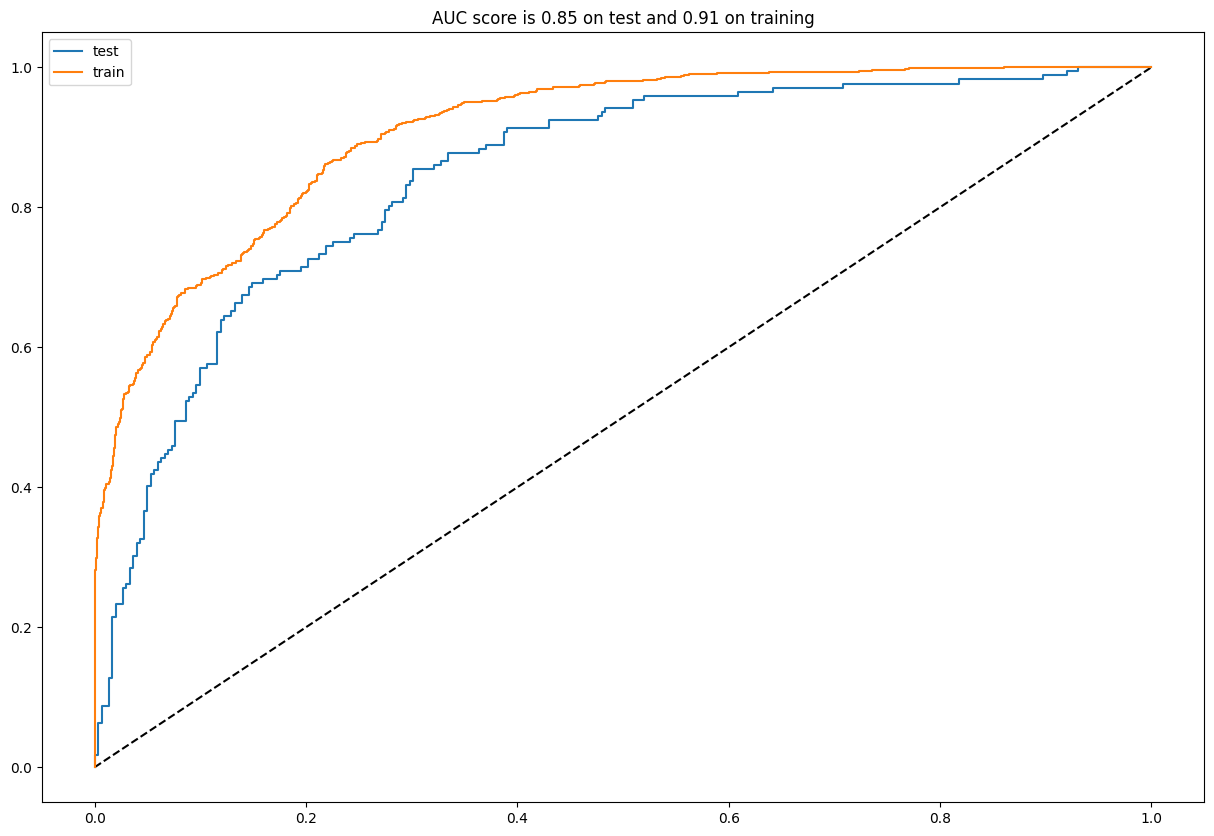

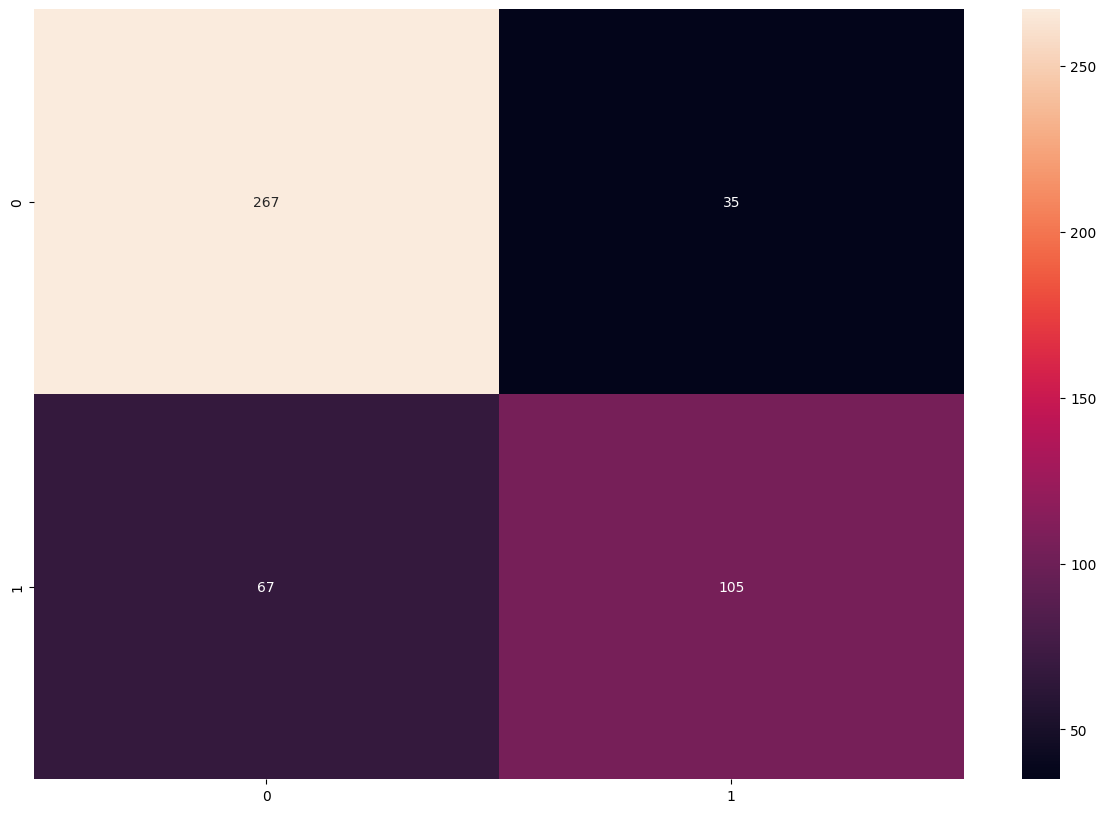

In [16]:
analyze(gb)

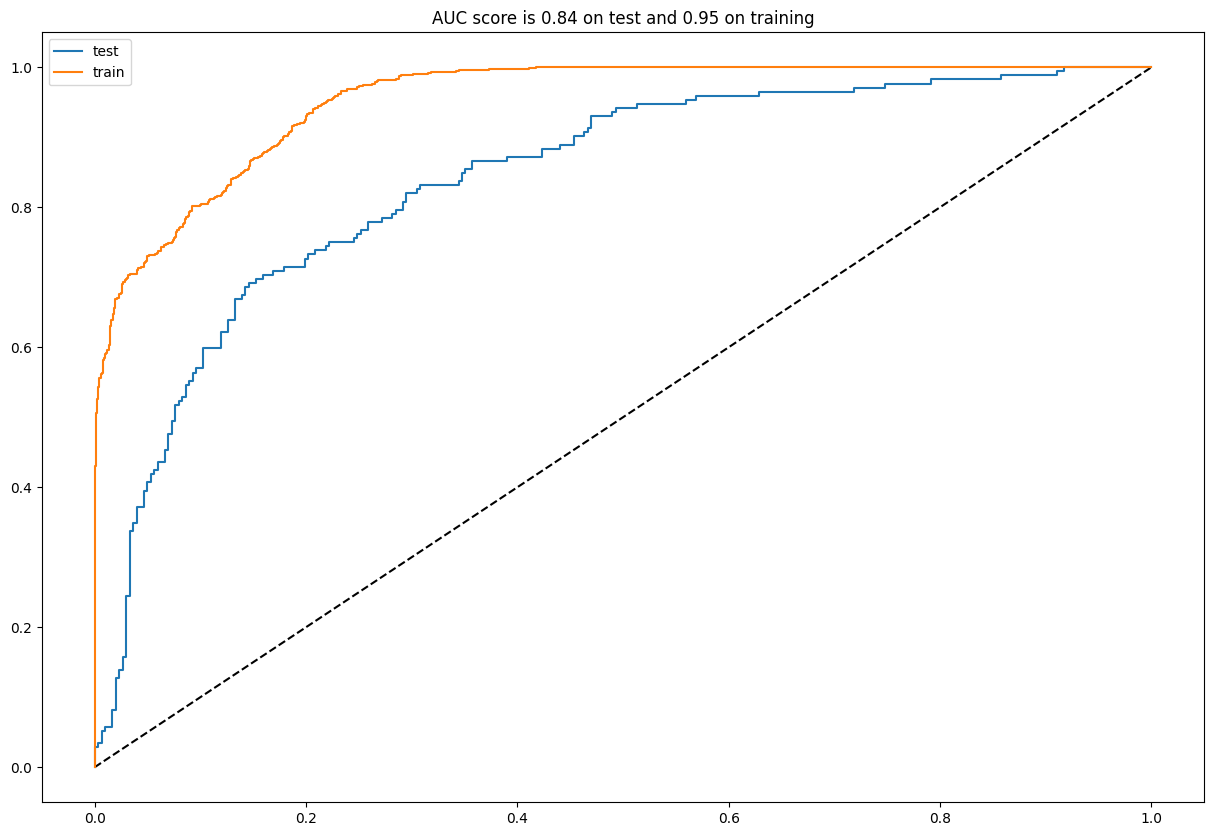

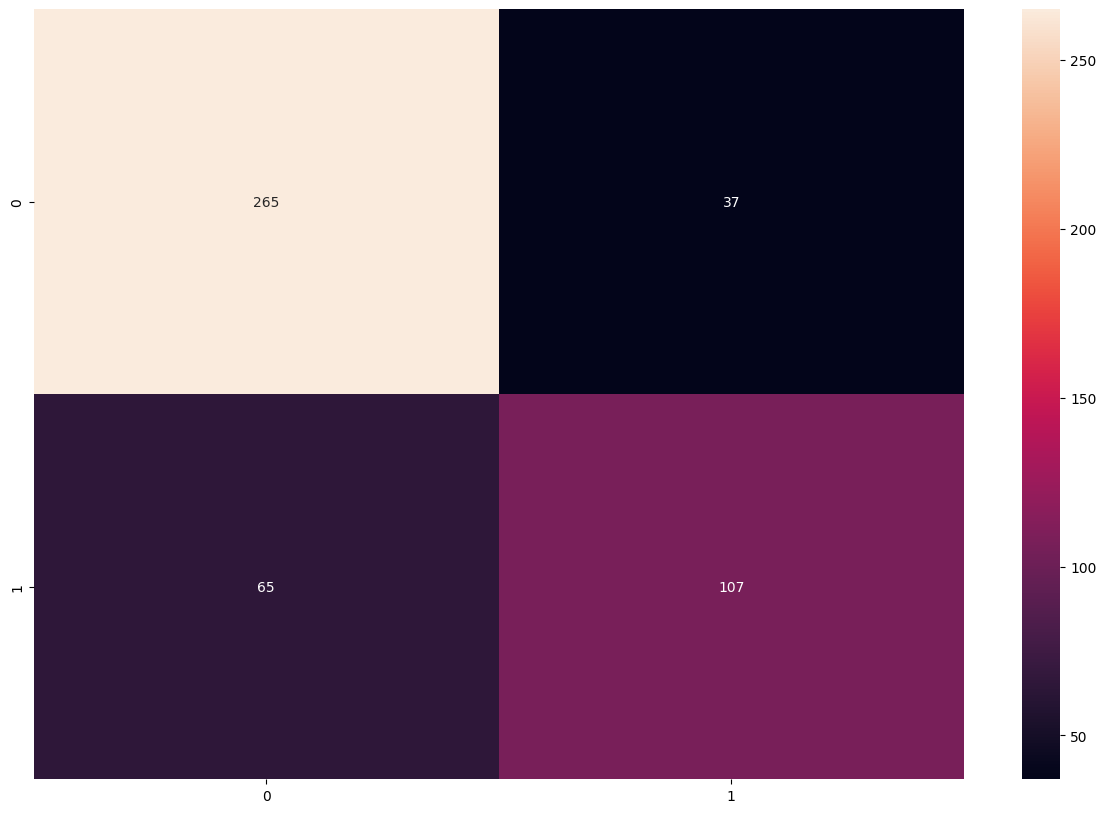

In [17]:
analyze(rf)

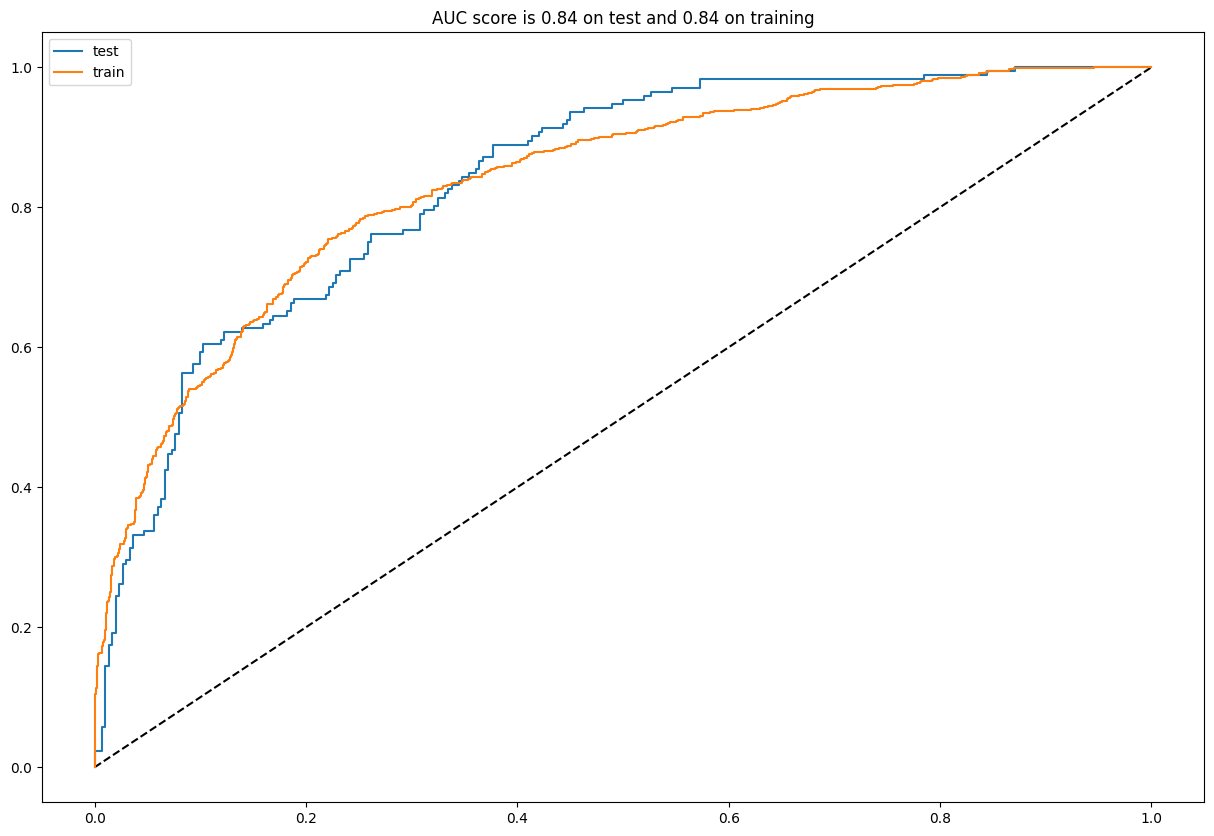

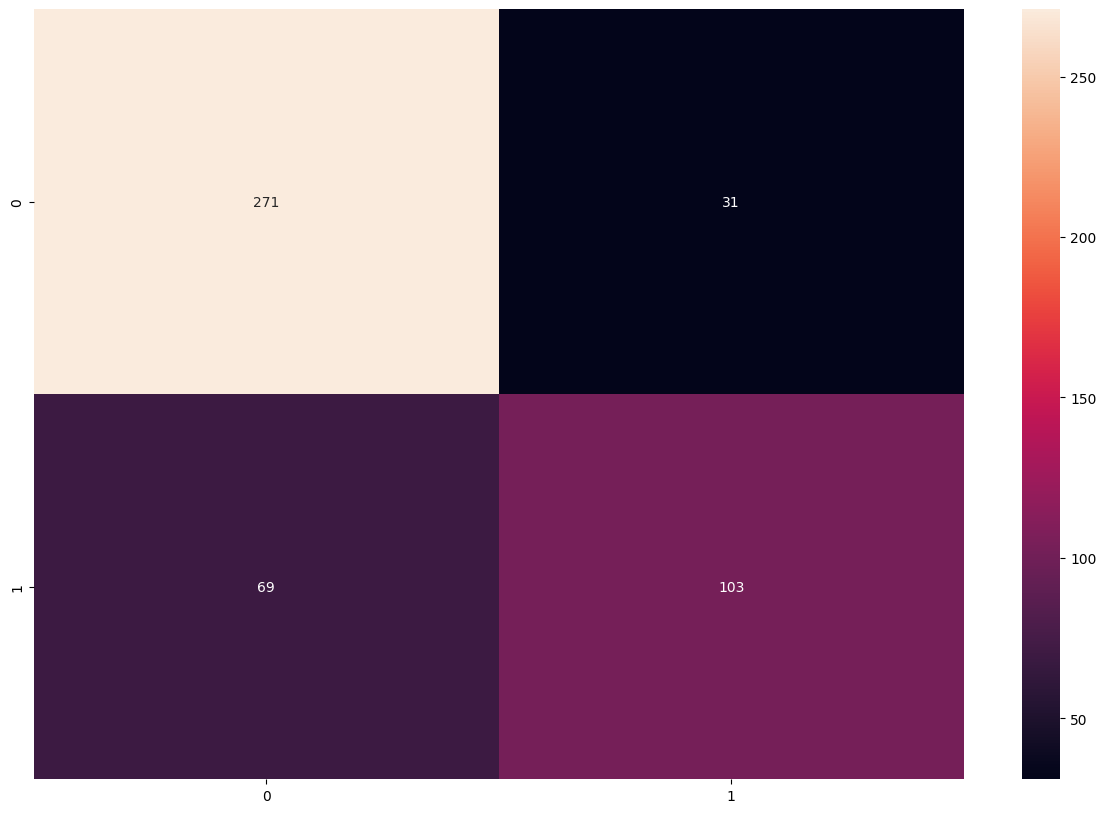

In [18]:
analyze(rlog)

The Random Forest model is a little bit better but seems to underfit. So, we will use the Gradient Boosting Model.

# Simulação da Copa

Para podermos simularmos os jogos, primeiramente vamos realizar um Web Scraping do Wikipédia para conseguirmos pegar os grupos, times e partidas da primeira fase. 

In [19]:
dfs = pd.read_html(r"https://en.wikipedia.org/wiki/2022_FIFA_World_Cup#Teams")

In [20]:
dfs[13]

,Pos,"Team.mw-parser-output .navbar{display:inline;font-size:88%;font-weight:normal}.mw-parser-output .navbar-collapse{float:left;text-align:left}.mw-parser-output .navbar-boxtext{word-spacing:0}.mw-parser-output .navbar ul{display:inline-block;white-space:nowrap;line-height:inherit}.mw-parser-output .navbar-brackets::before{margin-right:-0.125em;content:""[ ""}.mw-parser-output .navbar-brackets::after{margin-left:-0.125em;content:"" ]""}.mw-parser-output .navbar li{word-spacing:-0.125em}.mw-parser-output .navbar a>span,.mw-parser-output .navbar a>abbr{text-decoration:inherit}.mw-parser-output .navbar-mini abbr{font-variant:small-caps;border-bottom:none;text-decoration:none;cursor:inherit}.mw-parser-output .navbar-ct-full{font-size:114%;margin:0 7em}.mw-parser-output .navbar-ct-mini{font-size:114%;margin:0 4em}vte",Pld,W,D,L,GF,GA,GD,Pts,Qualification
0,1,Netherlands,1,1,0,0,2,0,+2,3[a],Advance to knockout stage
1,2,Ecuador,1,1,0,0,2,0,+2,3[a],Advance to knockout stage
2,3,Senegal,1,0,0,1,0,2,−2,0[b],NaN
3,4,Qatar (H),1,0,0,1,0,2,−2,0[b],NaN


In [21]:
matches = []
groups = ["A", "B", "C", "D", "E", "F", "G", "H"]
group_count = 0 

table = {}
#TABLE -> TEAM, POINTS, WIN PROBS (CRITERIO DE DESEMPATE)
table[groups[group_count]] = [[a.split(" ")[0], 0, []] for a in list(dfs[13].iloc[:, 1].values)]

In [22]:
for i in range(14, 69, 1):
    if len(dfs[i].columns) == 3:
        team_1 = dfs[i].columns.values[0]
        team_2 = dfs[i].columns.values[-1]
        matches.append((groups[group_count], team_1, team_2))
    else:
        group_count+=1
        table[groups[group_count]] = [[a, 0, []] for a in list(dfs[i].iloc[:, 1].values)]

In [23]:
import copy

In [24]:
table_rf = copy.deepcopy(table)
table_rlog = copy.deepcopy(table)

Com a construção do grupo e os participante, é possível armazenar os pontos dos times e a probabilidade de ganhar cada jogo. 

Caso exista empate nos pontos, a probabilidade de vencer vai ser usada como desempate (na realidade, é a verdadeira métrica para avanço).

In [25]:
matches[:10]

[('A', 'Qatar', 'Ecuador'),
 ('A', 'Senegal', 'Netherlands'),
 ('A', 'Qatar', 'Senegal'),
 ('A', 'Netherlands', 'Ecuador'),
 ('A', 'Ecuador', 'Senegal'),
 ('A', 'Netherlands', 'Qatar'),
 ('B', 'England', 'Iran'),
 ('B', 'United States', 'Wales'),
 ('B', 'Wales', 'Iran'),
 ('B', 'England', 'United States')]

Para a construção das variáveis vamos utilizar a última partida do time para que possamos pegar os valores de cada covariável.


In [26]:
team_stats_raw

,date,team,score,suf_score,rank,rank_suf,rank_change,total_points,result,rank_dif,points_by_rank,team_points,country_classification,points_by_classification
0,2018-07-01,Russia,1.0,1.0,49.0,6.0,-12.0,1758.00,2,43.0,0.166667,1,6,1.00
1,2018-07-01,Croatia,1.0,1.0,12.0,15.0,-6.0,2036.00,2,-3.0,0.066667,1,2,0.50
2,2018-07-02,Brazil,2.0,0.0,4.0,10.0,1.0,2160.00,0,-6.0,0.300000,3,1,1.50
3,2018-07-02,Belgium,3.0,2.0,5.0,41.0,-1.0,2124.00,0,-36.0,0.073171,3,1,0.75
4,2018-07-03,Sweden,1.0,0.0,21.0,8.0,-1.0,1955.00,0,13.0,0.375000,3,4,3.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6725,2022-09-27,Serbia,2.0,0.0,25.0,36.0,0.0,1549.53,1,11.0,0.083333,3,4,0.75
6726,2022-09-27,Slovenia,1.0,1.0,65.0,20.0,0.0,1372.48,2,-45.0,0.050000,1,6,0.25
6727,2022-09-27,Cyprus,1.0,5.0,108.0,106.0,1.0,1180.52,0,-2.0,0.000000,0,8,0.00
6728,2022-09-27,Northern Ireland,1.0,3.0,58.0,49.0,0.0,1399.10,0,-9.0,0.000000,0,6,0.00


In [27]:
def find_stats(team_1):
#team_1 = "Qatar"
    past_games = team_stats_raw[(team_stats_raw["team"] == team_1)].sort_values("date")
    last5 = team_stats_raw[(team_stats_raw["team"] == team_1)].sort_values("date").tail(5)

    team_1_rank = past_games["rank"].values[-1]
    team_1_goals = past_games['score'].mean()
    team_1_goals_l5 = last5['score'].mean()
    team_1_goals_suf = past_games['suf_score'].mean()
    team_1_goals_suf_l5 = last5['suf_score'].mean()
    team_1_rank_suf = past_games['rank_suf'].mean()
    team_1_rank_suf_l5 = last5['rank_suf'].mean()
    team_1_gp_rank = past_games['points_by_rank'].mean()
    team_1_gp_rank_l5 = last5['points_by_rank'].mean()
    team_1_points_by_classification = past_games['points_by_classification'].mean()

    return [team_1_rank, team_1_goals, team_1_goals_l5, team_1_goals_suf, team_1_goals_suf_l5, team_1_rank_suf, team_1_rank_suf_l5, team_1_gp_rank, team_1_gp_rank_l5, team_1_points_by_classification]

In [28]:
def find_features(team_1, team_2):
    rank_dif = team_1[0] - team_2[0]
    goals_dif = team_1[1] - team_2[1]
    goals_dif_l5 = team_1[2] - team_2[2]
    goals_suf_dif = team_1[3] - team_2[3]
    goals_suf_dif_l5 = team_1[4] - team_2[4]
    goals_per_ranking_dif = (team_1[1]/team_1[5]) - (team_2[1]/team_2[5])
    dif_rank_agst = team_1[5] - team_2[5]
    dif_rank_agst_l5 = team_1[6] - team_2[6]
    dif_gp_rank = team_1[7] - team_2[7]
    dif_gp_rank_l5 = team_1[8] - team_2[8]
    dif_points_by_classification = team_1[9] - team_2[9]
    
    return [rank_dif, goals_dif, goals_dif_l5, goals_suf_dif, goals_suf_dif_l5, goals_per_ranking_dif, dif_rank_agst, dif_rank_agst_l5, dif_gp_rank, dif_gp_rank_l5, 1, 0, dif_points_by_classification]

Now, we are able to simulate.

Since the model simulates if team 1 will win or not win, it's needed to create some criteria to define a draw. Also, since we have not home advantage at World Cup, the idea is to predict game two times, changing team 1 and team 2. The team with the highest mean of probabilities will be assigned as winner. At the group phase, if "home team" win as team 1 and loses as team 2, or if "home team" win as team 2 and loses at team 1, there will be assigned a draw in that match.

In [29]:
X.columns

Index(['rank_dif', 'goals_dif', 'goals_dif_l5', 'goals_suf_dif',
       'goals_suf_dif_l5', 'goals_per_ranking_dif', 'dif_rank_agst',
       'dif_rank_agst_l5', 'dif_points_rank', 'dif_points_rank_l5',
       'is_friendly_0', 'is_friendly_1', 'dif_points_by_classification'],
      dtype='object')

In [30]:
advanced_group = []
last_group = ""

for k in table.keys():
    for t in table[k]:
        t[1] = 0
        t[2] = []
        
for teams in matches:
    draw = False
    team_1 = find_stats(teams[1])
    team_2 = find_stats(teams[2])

    

    features_g1 = find_features(team_1, team_2)
    features_g2 = find_features(team_2, team_1)

    probs_g1 = gb.predict_proba([features_g1])
    probs_g2 = gb.predict_proba([features_g2])
    
    team_1_prob_g1 = probs_g1[0][0] # Probabilidade de vitória do time 1 em casa
    team_1_prob_g2 = probs_g2[0][1] # Probabilidade de vitória do time 1 fora de casa
    team_2_prob_g1 = probs_g1[0][1] # Probabilidade de vitória do time 2 fora de casa
    team_2_prob_g2 = probs_g2[0][0] # Probabilidade de vitória do time 2 em casa

    team_1_prob = (probs_g1[0][0] + probs_g2[0][1])/2
    team_2_prob = (probs_g2[0][0] + probs_g1[0][1])/2
    
    if ((team_1_prob_g1 > team_2_prob_g1) & (team_2_prob_g2 > team_1_prob_g2)) | ((team_1_prob_g1 < team_2_prob_g1) & (team_2_prob_g2 < team_1_prob_g2)):
        draw=True
        for i in table[teams[0]]:
            if i[0] == teams[1] or i[0] == teams[2]:
                i[1] += 1
                
    elif team_1_prob > team_2_prob:
        winner = teams[1]
        winner_proba = team_1_prob
        for i in table[teams[0]]:
            if i[0] == teams[1]:
                i[1] += 3
                
    elif team_2_prob > team_1_prob:  
        winner = teams[2]
        winner_proba = team_2_prob
        for i in table[teams[0]]:
            if i[0] == teams[2]:
                i[1] += 3
    
    for i in table[teams[0]]: #adding criterio de desempate (probs por jogo)
            if i[0] == teams[1]:
                i[2].append(team_1_prob)
            if i[0] == teams[2]:
                i[2].append(team_2_prob)

    if last_group != teams[0]:
        if last_group != "":
            print("\n")
            print("Grupo %s classificados: "%(last_group))
            
            for i in table[last_group]: #adding crieterio de desempate
                i[2] = np.mean(i[2])
            
            final_points = table[last_group]
            final_table = sorted(final_points, key=itemgetter(1, 2), reverse = True)
            advanced_group.append([final_table[0][0], final_table[1][0]])
            for i in final_table:
                print("%s -------- %d"%(i[0], i[1]))
        print("\n")
        print("-"*10+" Começando a simulação para o Grupo %s "%(teams[0])+"-"*10)
        
        
    if draw == False:
        print("Grupo %s - %s x %s: vencedor %s com %.2f probabilidade"%(teams[0], teams[1], teams[2], winner, winner_proba))
    else:
        print("Grupo %s - %s x %s: Empate"%(teams[0], teams[1], teams[2]))
    last_group =  teams[0]

print("\n")
print("Group %s advanced: "%(last_group))

for i in table[last_group]: #adding crieterio de desempate
    i[2] = np.mean(i[2])
            
final_points = table[last_group]
final_table = sorted(final_points, key=itemgetter(1, 2), reverse = True)
advanced_group.append([final_table[0][0], final_table[1][0]])
for i in final_table:
    print("%s -------- %d"%(i[0], i[1]))



---------- Começando a simulação para o Grupo A ----------
Grupo A - Qatar x Ecuador: Empate
Grupo A - Senegal x Netherlands: vencedor Netherlands com 0.64 probabilidade
Grupo A - Qatar x Senegal: vencedor Senegal com 0.68 probabilidade
Grupo A - Netherlands x Ecuador: vencedor Netherlands com 0.71 probabilidade
Grupo A - Ecuador x Senegal: vencedor Senegal com 0.65 probabilidade
Grupo A - Netherlands x Qatar: Empate


Grupo A classificados: 
Netherlands -------- 7
Senegal -------- 6
Qatar -------- 2
Ecuador -------- 1


---------- Começando a simulação para o Grupo B ----------
Grupo B - England x Iran: vencedor England com 0.67 probabilidade
Grupo B - United States x Wales: Empate
Grupo B - Wales x Iran: Empate
Grupo B - England x United States: vencedor England com 0.62 probabilidade
Grupo B - Wales x England: Empate
Grupo B - Iran x United States: Empate


Grupo B classificados: 
England -------- 7
Wales -------- 3
United States -------- 2
Iran -------- 2


---------- Começando a

The group phase predicted no surprises, or maybe the draw between Brazil and Switzerland or France and Denmark. For the playoffs phase, I'll predict and show it graphically as made [here](https://www.kaggle.com/code/agostontorok/soccer-world-cup-2018-winner). 

In [31]:
advanced = advanced_group

In [32]:
advanced

[['Netherlands', 'Senegal'],
 ['England', 'Wales'],
 ['Argentina', 'Mexico'],
 ['France', 'Tunisia'],
 ['Spain', 'Germany'],
 ['Belgium', 'Morocco'],
 ['Brazil', 'Switzerland'],
 ['Portugal', 'Uruguay']]

In [33]:
playoffs = {"Round of 16": [], "Quarter-Final": [], "Semi-Final": [], "Final": []}

In [34]:
for p in playoffs.keys():
    playoffs[p] = []

actual_round = ""
next_rounds = []

for p in playoffs.keys():
    if p == "Round of 16":
        control = []
        for a in range(0, len(advanced*2), 1):
            if a < len(advanced):
                if a % 2 == 0:
                    control.append((advanced*2)[a][0])
                else:
                    control.append((advanced*2)[a][1])
            else:
                if a % 2 == 0:
                    control.append((advanced*2)[a][1])
                else:
                    control.append((advanced*2)[a][0])

        playoffs[p] = [[control[c], control[c+1]] for c in range(0, len(control)-1, 1) if c%2 == 0]
        
        for i in range(0, len(playoffs[p]), 1):
            game = playoffs[p][i]
            
            home = game[0]
            away = game[1]
            team_1 = find_stats(home)
            team_2 = find_stats(away)

            features_g1 = find_features(team_1, team_2)
            features_g2 = find_features(team_2, team_1)
            
            probs_g1 = gb.predict_proba([features_g1])
            probs_g2 = gb.predict_proba([features_g2])
            
            team_1_prob = (probs_g1[0][0] + probs_g2[0][1])/2
            team_2_prob = (probs_g2[0][0] + probs_g1[0][1])/2
            
            if actual_round != p:
                print("-"*10)
                print("Starting simulation of %s"%(p))
                print("-"*10)
                print("\n")
            
            if team_1_prob < team_2_prob:
                print("%s vs. %s: %s advances with prob %.2f"%(home, away, away, team_2_prob))
                next_rounds.append(away)
            else:
                print("%s vs. %s: %s advances with prob %.2f"%(home, away, home, team_1_prob))
                next_rounds.append(home)
            
            game.append([team_1_prob, team_2_prob])
            playoffs[p][i] = game
            actual_round = p
        
    else:
        playoffs[p] = [[next_rounds[c], next_rounds[c+1]] for c in range(0, len(next_rounds)-1, 1) if c%2 == 0]
        next_rounds = []
        for i in range(0, len(playoffs[p])):
            game = playoffs[p][i]
            home = game[0]
            away = game[1]
            team_1 = find_stats(home)
            team_2 = find_stats(away)
            
            features_g1 = find_features(team_1, team_2)
            features_g2 = find_features(team_2, team_1)
            
            probs_g1 = gb.predict_proba([features_g1])
            probs_g2 = gb.predict_proba([features_g2])
            
            team_1_prob = (probs_g1[0][0] + probs_g2[0][1])/2
            team_2_prob = (probs_g2[0][0] + probs_g1[0][1])/2
            
            if actual_round != p:
                print("-"*10)
                print("Starting simulation of %s"%(p))
                print("-"*10)
                print("\n")
            
            if team_1_prob < team_2_prob:
                print("%s vs. %s: %s advances with prob %.2f"%(home, away, away, team_2_prob))
                next_rounds.append(away)
            else:
                print("%s vs. %s: %s advances with prob %.2f"%(home, away, home, team_1_prob))
                next_rounds.append(home)
            game.append([team_1_prob, team_2_prob])
            playoffs[p][i] = game
            actual_round = p
            

----------
Starting simulation of Round of 16
----------


Netherlands vs. Wales: Netherlands advances with prob 0.60
Argentina vs. Tunisia: Argentina advances with prob 0.64
Spain vs. Morocco: Spain advances with prob 0.61
Brazil vs. Uruguay: Brazil advances with prob 0.64
Senegal vs. England: England advances with prob 0.66
Mexico vs. France: France advances with prob 0.51
Germany vs. Belgium: Belgium advances with prob 0.56
Switzerland vs. Portugal: Portugal advances with prob 0.54
----------
Starting simulation of Quarter-Final
----------


Netherlands vs. Argentina: Argentina advances with prob 0.54
Spain vs. Brazil: Brazil advances with prob 0.58
England vs. France: France advances with prob 0.55
Belgium vs. Portugal: Belgium advances with prob 0.60
----------
Starting simulation of Semi-Final
----------


Argentina vs. Brazil: Brazil advances with prob 0.53
France vs. Belgium: Belgium advances with prob 0.52
----------
Starting simulation of Final
----------


Brazil vs. Belgium

## Random forest

In [35]:
table = table_rf

In [36]:
advanced_group = []
last_group = ""

for k in table.keys():
    for t in table[k]:
        t[1] = 0
        t[2] = []
        
for teams in matches:
    draw = False
    team_1 = find_stats(teams[1])
    team_2 = find_stats(teams[2])

    

    features_g1 = find_features(team_1, team_2)
    features_g2 = find_features(team_2, team_1)

    probs_g1 = rf.predict_proba([features_g1])
    probs_g2 = rf.predict_proba([features_g2])
    
    team_1_prob_g1 = probs_g1[0][0] # Probabilidade de vitória do time 1 em casa
    team_1_prob_g2 = probs_g2[0][1] # Probabilidade de vitória do time 1 fora de casa
    team_2_prob_g1 = probs_g1[0][1] # Probabilidade de vitória do time 2 fora de casa
    team_2_prob_g2 = probs_g2[0][0] # Probabilidade de vitória do time 2 em casa

    team_1_prob = (probs_g1[0][0] + probs_g2[0][1])/2
    team_2_prob = (probs_g2[0][0] + probs_g1[0][1])/2
    
    if ((team_1_prob_g1 > team_2_prob_g1) & (team_2_prob_g2 > team_1_prob_g2)) | ((team_1_prob_g1 < team_2_prob_g1) & (team_2_prob_g2 < team_1_prob_g2)):
        draw=True
        for i in table[teams[0]]:
            if i[0] == teams[1] or i[0] == teams[2]:
                i[1] += 1
                
    elif team_1_prob > team_2_prob:
        winner = teams[1]
        winner_proba = team_1_prob
        for i in table[teams[0]]:
            if i[0] == teams[1]:
                i[1] += 3
                
    elif team_2_prob > team_1_prob:  
        winner = teams[2]
        winner_proba = team_2_prob
        for i in table[teams[0]]:
            if i[0] == teams[2]:
                i[1] += 3
    
    for i in table[teams[0]]: #adding criterio de desempate (probs por jogo)
            if i[0] == teams[1]:
                i[2].append(team_1_prob)
            if i[0] == teams[2]:
                i[2].append(team_2_prob)

    if last_group != teams[0]:
        if last_group != "":
            print("\n")
            print("Grupo %s classificados: "%(last_group))
            
            for i in table[last_group]: #adding crieterio de desempate
                i[2] = np.mean(i[2])
            
            final_points = table[last_group]
            final_table = sorted(final_points, key=itemgetter(1, 2), reverse = True)
            advanced_group.append([final_table[0][0], final_table[1][0]])
            for i in final_table:
                print("%s -------- %d"%(i[0], i[1]))
        print("\n")
        print("-"*10+" Começando a simulação para o Grupo %s "%(teams[0])+"-"*10)
        
        
    if draw == False:
        print("Grupo %s - %s x %s: vencedor %s com %.2f probabilidade"%(teams[0], teams[1], teams[2], winner, winner_proba))
    else:
        print("Grupo %s - %s x %s: Empate"%(teams[0], teams[1], teams[2]))
    last_group =  teams[0]

print("\n")
print("Group %s advanced: "%(last_group))

for i in table[last_group]: #adding crieterio de desempate
    i[2] = np.mean(i[2])
            
final_points = table[last_group]
final_table = sorted(final_points, key=itemgetter(1, 2), reverse = True)
advanced_group.append([final_table[0][0], final_table[1][0]])
for i in final_table:
    print("%s -------- %d"%(i[0], i[1]))



---------- Começando a simulação para o Grupo A ----------
Grupo A - Qatar x Ecuador: Empate
Grupo A - Senegal x Netherlands: vencedor Netherlands com 0.63 probabilidade
Grupo A - Qatar x Senegal: vencedor Senegal com 0.75 probabilidade
Grupo A - Netherlands x Ecuador: vencedor Netherlands com 0.74 probabilidade
Grupo A - Ecuador x Senegal: vencedor Senegal com 0.68 probabilidade
Grupo A - Netherlands x Qatar: vencedor Netherlands com 0.68 probabilidade


Grupo A classificados: 
Netherlands -------- 9
Senegal -------- 6
Qatar -------- 1
Ecuador -------- 1


---------- Começando a simulação para o Grupo B ----------
Grupo B - England x Iran: vencedor England com 0.69 probabilidade
Grupo B - United States x Wales: Empate
Grupo B - Wales x Iran: Empate
Grupo B - England x United States: vencedor England com 0.60 probabilidade
Grupo B - Wales x England: Empate
Grupo B - Iran x United States: Empate


Grupo B classificados: 
England -------- 7
Wales -------- 3
United States -------- 2
Ira

In [37]:
advanced = advanced_group

In [38]:
advanced

[['Netherlands', 'Senegal'],
 ['England', 'Wales'],
 ['Argentina', 'Mexico'],
 ['France', 'Denmark'],
 ['Spain', 'Germany'],
 ['Belgium', 'Morocco'],
 ['Brazil', 'Switzerland'],
 ['Portugal', 'Uruguay']]

In [39]:
playoffs = {"Round of 16": [], "Quarter-Final": [], "Semi-Final": [], "Final": []}

In [40]:
for p in playoffs.keys():
    playoffs[p] = []

actual_round = ""
next_rounds = []

for p in playoffs.keys():
    if p == "Round of 16":
        control = []
        for a in range(0, len(advanced*2), 1):
            if a < len(advanced):
                if a % 2 == 0:
                    control.append((advanced*2)[a][0])
                else:
                    control.append((advanced*2)[a][1])
            else:
                if a % 2 == 0:
                    control.append((advanced*2)[a][1])
                else:
                    control.append((advanced*2)[a][0])

        playoffs[p] = [[control[c], control[c+1]] for c in range(0, len(control)-1, 1) if c%2 == 0]
        
        for i in range(0, len(playoffs[p]), 1):
            game = playoffs[p][i]
            
            home = game[0]
            away = game[1]
            team_1 = find_stats(home)
            team_2 = find_stats(away)

            features_g1 = find_features(team_1, team_2)
            features_g2 = find_features(team_2, team_1)
            
            probs_g1 = rf.predict_proba([features_g1])
            probs_g2 = rf.predict_proba([features_g2])
            
            team_1_prob = (probs_g1[0][0] + probs_g2[0][1])/2
            team_2_prob = (probs_g2[0][0] + probs_g1[0][1])/2
            
            if actual_round != p:
                print("-"*10)
                print("Starting simulation of %s"%(p))
                print("-"*10)
                print("\n")
            
            if team_1_prob < team_2_prob:
                print("%s vs. %s: %s advances with prob %.2f"%(home, away, away, team_2_prob))
                next_rounds.append(away)
            else:
                print("%s vs. %s: %s advances with prob %.2f"%(home, away, home, team_1_prob))
                next_rounds.append(home)
            
            game.append([team_1_prob, team_2_prob])
            playoffs[p][i] = game
            actual_round = p
        
    else:
        playoffs[p] = [[next_rounds[c], next_rounds[c+1]] for c in range(0, len(next_rounds)-1, 1) if c%2 == 0]
        next_rounds = []
        for i in range(0, len(playoffs[p])):
            game = playoffs[p][i]
            home = game[0]
            away = game[1]
            team_1 = find_stats(home)
            team_2 = find_stats(away)
            
            features_g1 = find_features(team_1, team_2)
            features_g2 = find_features(team_2, team_1)
            
            probs_g1 = rf.predict_proba([features_g1])
            probs_g2 = rf.predict_proba([features_g2])
            
            team_1_prob = (probs_g1[0][0] + probs_g2[0][1])/2
            team_2_prob = (probs_g2[0][0] + probs_g1[0][1])/2
            
            if actual_round != p:
                print("-"*10)
                print("Starting simulation of %s"%(p))
                print("-"*10)
                print("\n")
            
            if team_1_prob < team_2_prob:
                print("%s vs. %s: %s advances with prob %.2f"%(home, away, away, team_2_prob))
                next_rounds.append(away)
            else:
                print("%s vs. %s: %s advances with prob %.2f"%(home, away, home, team_1_prob))
                next_rounds.append(home)
            game.append([team_1_prob, team_2_prob])
            playoffs[p][i] = game
            actual_round = p
            

----------
Starting simulation of Round of 16
----------


Netherlands vs. Wales: Netherlands advances with prob 0.60
Argentina vs. Denmark: Argentina advances with prob 0.58
Spain vs. Morocco: Spain advances with prob 0.62
Brazil vs. Uruguay: Brazil advances with prob 0.65
Senegal vs. England: England advances with prob 0.68
Mexico vs. France: Mexico advances with prob 0.50
Germany vs. Belgium: Belgium advances with prob 0.61
Switzerland vs. Portugal: Portugal advances with prob 0.56
----------
Starting simulation of Quarter-Final
----------


Netherlands vs. Argentina: Argentina advances with prob 0.58
Spain vs. Brazil: Brazil advances with prob 0.60
England vs. Mexico: England advances with prob 0.56
Belgium vs. Portugal: Belgium advances with prob 0.60
----------
Starting simulation of Semi-Final
----------


Argentina vs. Brazil: Brazil advances with prob 0.53
England vs. Belgium: Belgium advances with prob 0.55
----------
Starting simulation of Final
----------


Brazil vs. Belgi

## Regressão Logística

In [41]:
table = table_rlog

In [42]:
advanced_group = []
last_group = ""

for k in table.keys():
    for t in table[k]:
        t[1] = 0
        t[2] = []
        
for teams in matches:
    draw = False
    team_1 = find_stats(teams[1])
    team_2 = find_stats(teams[2])

    

    features_g1 = find_features(team_1, team_2)
    features_g2 = find_features(team_2, team_1)

    probs_g1 = rlog.predict_proba([features_g1])
    probs_g2 = rlog.predict_proba([features_g2])
    
    team_1_prob_g1 = probs_g1[0][0] # Probabilidade de vitória do time 1 em casa
    team_1_prob_g2 = probs_g2[0][1] # Probabilidade de vitória do time 1 fora de casa
    team_2_prob_g1 = probs_g1[0][1] # Probabilidade de vitória do time 2 fora de casa
    team_2_prob_g2 = probs_g2[0][0] # Probabilidade de vitória do time 2 em casa

    team_1_prob = (probs_g1[0][0] + probs_g2[0][1])/2
    team_2_prob = (probs_g2[0][0] + probs_g1[0][1])/2
    
    if ((team_1_prob_g1 > team_2_prob_g1) & (team_2_prob_g2 > team_1_prob_g2)) | ((team_1_prob_g1 < team_2_prob_g1) & (team_2_prob_g2 < team_1_prob_g2)):
        draw=True
        for i in table[teams[0]]:
            if i[0] == teams[1] or i[0] == teams[2]:
                i[1] += 1
                
    elif team_1_prob > team_2_prob:
        winner = teams[1]
        winner_proba = team_1_prob
        for i in table[teams[0]]:
            if i[0] == teams[1]:
                i[1] += 3
                
    elif team_2_prob > team_1_prob:  
        winner = teams[2]
        winner_proba = team_2_prob
        for i in table[teams[0]]:
            if i[0] == teams[2]:
                i[1] += 3
    
    for i in table[teams[0]]: #adding criterio de desempate (probs por jogo)
            if i[0] == teams[1]:
                i[2].append(team_1_prob)
            if i[0] == teams[2]:
                i[2].append(team_2_prob)

    if last_group != teams[0]:
        if last_group != "":
            print("\n")
            print("Grupo %s classificados: "%(last_group))
            
            for i in table[last_group]: #adding crieterio de desempate
                i[2] = np.mean(i[2])
            
            final_points = table[last_group]
            final_table = sorted(final_points, key=itemgetter(1, 2), reverse = True)
            advanced_group.append([final_table[0][0], final_table[1][0]])
            for i in final_table:
                print("%s -------- %d"%(i[0], i[1]))
        print("\n")
        print("-"*10+" Começando a simulação para o Grupo %s "%(teams[0])+"-"*10)
        
        
    if draw == False:
        print("Grupo %s - %s x %s: vencedor %s com %.2f probabilidade"%(teams[0], teams[1], teams[2], winner, winner_proba))
    else:
        print("Grupo %s - %s x %s: Empate"%(teams[0], teams[1], teams[2]))
    last_group =  teams[0]

print("\n")
print("Group %s advanced: "%(last_group))

for i in table[last_group]: #adding crieterio de desempate
    i[2] = np.mean(i[2])
            
final_points = table[last_group]
final_table = sorted(final_points, key=itemgetter(1, 2), reverse = True)
advanced_group.append([final_table[0][0], final_table[1][0]])
for i in final_table:
    print("%s -------- %d"%(i[0], i[1]))



---------- Começando a simulação para o Grupo A ----------
Grupo A - Qatar x Ecuador: Empate
Grupo A - Senegal x Netherlands: Empate
Grupo A - Qatar x Senegal: vencedor Senegal com 0.74 probabilidade
Grupo A - Netherlands x Ecuador: vencedor Netherlands com 0.79 probabilidade
Grupo A - Ecuador x Senegal: vencedor Senegal com 0.77 probabilidade
Grupo A - Netherlands x Qatar: vencedor Netherlands com 0.76 probabilidade


Grupo A classificados: 
Netherlands -------- 7
Senegal -------- 7
Qatar -------- 1
Ecuador -------- 1


---------- Começando a simulação para o Grupo B ----------
Grupo B - England x Iran: Empate
Grupo B - United States x Wales: Empate
Grupo B - Wales x Iran: Empate
Grupo B - England x United States: Empate
Grupo B - Wales x England: Empate
Grupo B - Iran x United States: Empate


Grupo B classificados: 
England -------- 3
Wales -------- 3
United States -------- 3
Iran -------- 3


---------- Começando a simulação para o Grupo C ----------
Grupo C - Argentina x Saudi A

In [43]:
advanced = advanced_group

In [44]:
advanced

[['Netherlands', 'Senegal'],
 ['England', 'Wales'],
 ['Argentina', 'Mexico'],
 ['France', 'Denmark'],
 ['Germany', 'Spain'],
 ['Belgium', 'Morocco'],
 ['Brazil', 'Switzerland'],
 ['Portugal', 'Uruguay']]

In [45]:
playoffs = {"Round of 16": [], "Quarter-Final": [], "Semi-Final": [], "Final": []}

In [46]:
for p in playoffs.keys():
    playoffs[p] = []

actual_round = ""
next_rounds = []

for p in playoffs.keys():
    if p == "Round of 16":
        control = []
        for a in range(0, len(advanced*2), 1):
            if a < len(advanced):
                if a % 2 == 0:
                    control.append((advanced*2)[a][0])
                else:
                    control.append((advanced*2)[a][1])
            else:
                if a % 2 == 0:
                    control.append((advanced*2)[a][1])
                else:
                    control.append((advanced*2)[a][0])

        playoffs[p] = [[control[c], control[c+1]] for c in range(0, len(control)-1, 1) if c%2 == 0]
        
        for i in range(0, len(playoffs[p]), 1):
            game = playoffs[p][i]
            
            home = game[0]
            away = game[1]
            team_1 = find_stats(home)
            team_2 = find_stats(away)

            features_g1 = find_features(team_1, team_2)
            features_g2 = find_features(team_2, team_1)
            
            probs_g1 = rlog.predict_proba([features_g1])
            probs_g2 = rlog.predict_proba([features_g2])
            
            team_1_prob = (probs_g1[0][0] + probs_g2[0][1])/2
            team_2_prob = (probs_g2[0][0] + probs_g1[0][1])/2
            
            if actual_round != p:
                print("-"*10)
                print("Starting simulation of %s"%(p))
                print("-"*10)
                print("\n")
            
            if team_1_prob < team_2_prob:
                print("%s vs. %s: %s advances with prob %.2f"%(home, away, away, team_2_prob))
                next_rounds.append(away)
            else:
                print("%s vs. %s: %s advances with prob %.2f"%(home, away, home, team_1_prob))
                next_rounds.append(home)
            
            game.append([team_1_prob, team_2_prob])
            playoffs[p][i] = game
            actual_round = p
        
    else:
        playoffs[p] = [[next_rounds[c], next_rounds[c+1]] for c in range(0, len(next_rounds)-1, 1) if c%2 == 0]
        next_rounds = []
        for i in range(0, len(playoffs[p])):
            game = playoffs[p][i]
            home = game[0]
            away = game[1]
            team_1 = find_stats(home)
            team_2 = find_stats(away)
            
            features_g1 = find_features(team_1, team_2)
            features_g2 = find_features(team_2, team_1)
            
            probs_g1 = rlog.predict_proba([features_g1])
            probs_g2 = rlog.predict_proba([features_g2])
            
            team_1_prob = (probs_g1[0][0] + probs_g2[0][1])/2
            team_2_prob = (probs_g2[0][0] + probs_g1[0][1])/2
            
            if actual_round != p:
                print("-"*10)
                print("Starting simulation of %s"%(p))
                print("-"*10)
                print("\n")
            
            if team_1_prob < team_2_prob:
                print("%s vs. %s: %s advances with prob %.2f"%(home, away, away, team_2_prob))
                next_rounds.append(away)
            else:
                print("%s vs. %s: %s advances with prob %.2f"%(home, away, home, team_1_prob))
                next_rounds.append(home)
            game.append([team_1_prob, team_2_prob])
            playoffs[p][i] = game
            actual_round = p
            

----------
Starting simulation of Round of 16
----------


Netherlands vs. Wales: Netherlands advances with prob 0.50
Argentina vs. Denmark: Argentina advances with prob 0.60
Germany vs. Morocco: Germany advances with prob 0.58
Brazil vs. Uruguay: Brazil advances with prob 0.66
Senegal vs. England: England advances with prob 0.56
Mexico vs. France: Mexico advances with prob 0.50
Spain vs. Belgium: Belgium advances with prob 0.53
Switzerland vs. Portugal: Portugal advances with prob 0.54
----------
Starting simulation of Quarter-Final
----------


Netherlands vs. Argentina: Argentina advances with prob 0.57
Germany vs. Brazil: Brazil advances with prob 0.63
England vs. Mexico: England advances with prob 0.54
Belgium vs. Portugal: Belgium advances with prob 0.53
----------
Starting simulation of Semi-Final
----------


Argentina vs. Brazil: Brazil advances with prob 0.56
England vs. Belgium: England advances with prob 0.50
----------
Starting simulation of Final
----------


Brazil vs. E

In [47]:
import networkx as nx
from networkx.drawing.nx_pydot import graphviz_layout

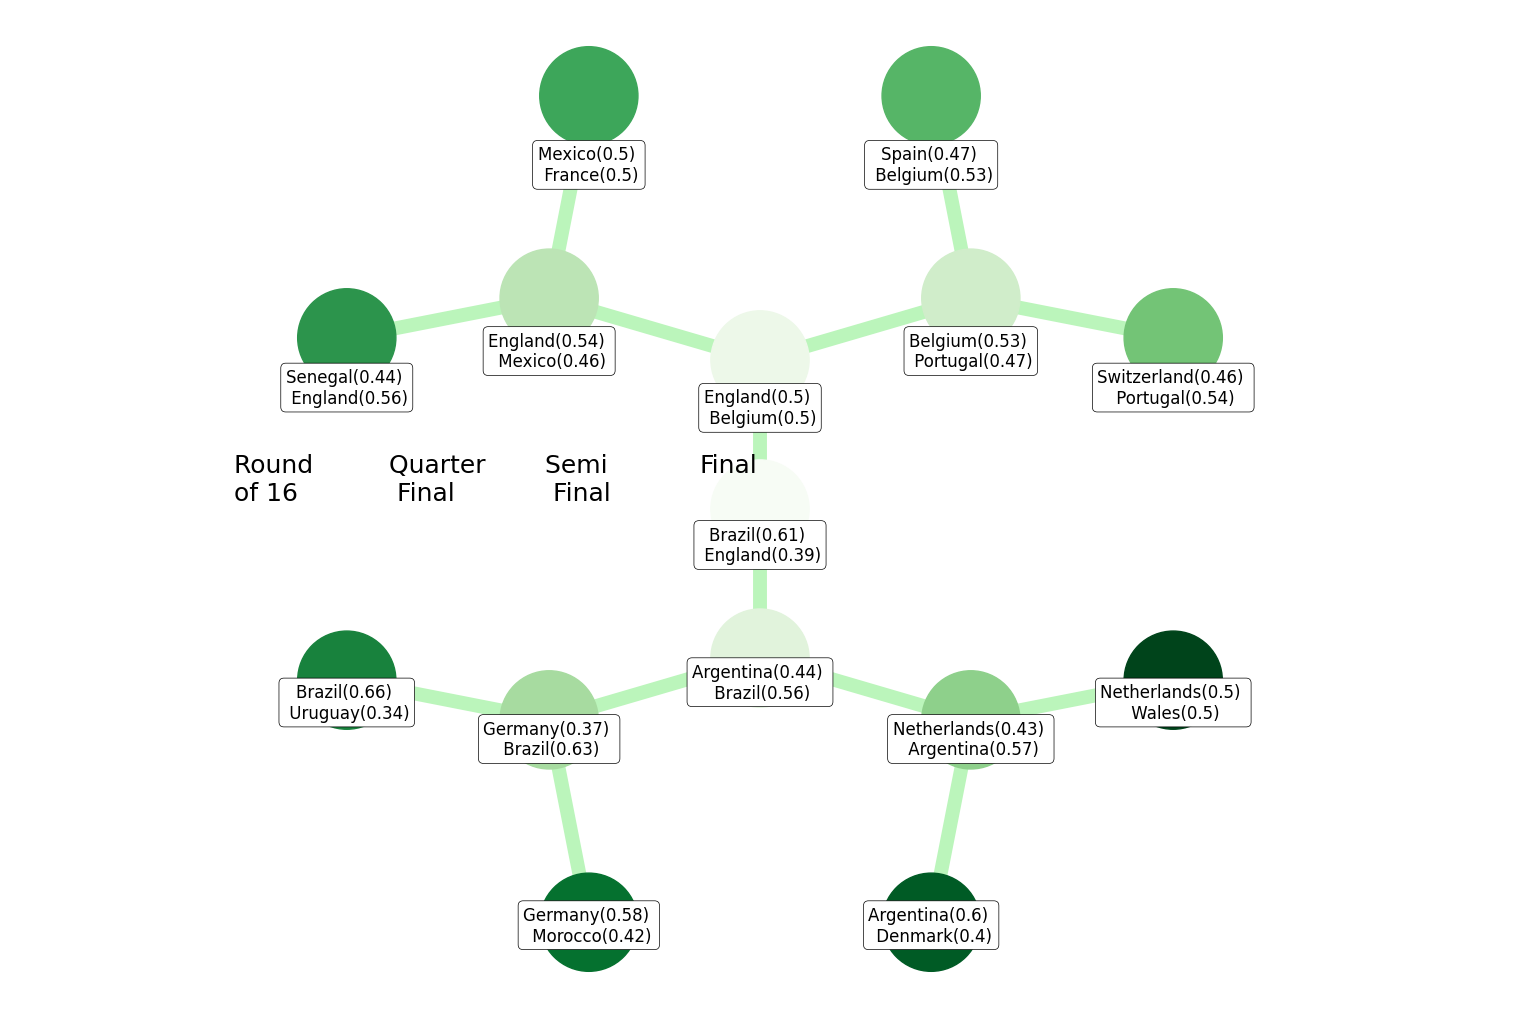

In [48]:
plt.figure(figsize=(15, 10))
G = nx.balanced_tree(2, 3)


labels = []


for p in playoffs.keys():
    for game in playoffs[p]:
        label = f"{game[0]}({round(game[2][0], 2)}) \n {game[1]}({round(game[2][1], 2)})"
        labels.append(label)
    
labels_dict = {}
labels_rev = list(reversed(labels))

for l in range(len(list(G.nodes))):
    labels_dict[l] = labels_rev[l]

pos = graphviz_layout(G, prog='twopi')
labels_pos = {n: (k[0], k[1]-0.08*k[1]) for n,k in pos.items()}
center  = pd.DataFrame(pos).mean(axis=1).mean()
    

nx.draw(G, pos = pos, with_labels=False, node_color=range(15), edge_color="#bbf5bb", width=10, font_weight='bold',cmap=plt.cm.Greens, node_size=5000)
nx.draw_networkx_labels(G, pos = labels_pos, bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=.5, alpha=1),
                        labels=labels_dict)
texts = ["Round \nof 16", "Quarter \n Final", "Semi \n Final", "Final\n"]
pos_y = pos[0][1] + 55
for text in reversed(texts):
    pos_x = center
    pos_y -= 75 
    plt.text(pos_y, pos_x, text, fontsize = 18)

plt.axis('equal')
plt.show()

And that's the final simulation! Brazil has won the 6th title! Hoping that my predictions are correct now. 

It's nice to analyze too the possible upsets. Belgium passed against Germany, and were defeated by Portugal. Argentina - Netherlands game is very tight, with Netherlands passing by nearly 1%. The same happens between France and England, with England passing. I think England as finalist was the biggest upset of the simulation.

# Conclusion

The goal of this was to improve my knowledge with Machine Learning simulating something that I love (Football World Cup). I think that's amazing to create models that we can see the result in real life, and that's what is going to happen!

In general, I think that the model predicted like the common sense of people who watch football. There are not huge surprises in the simulation. It's also nice to see games with teams that are more unkown in group phase, like Iran vs. Wales or Senegal vs. Ecuador. I think that in games like that, the model is a good guidance to betting, since the knowledge of most people second tier national teams is not great.